#DATASCI W261: Machine Learning at Scale

**Nick Hamlin** (nickhamlin@gmail.com)  
**Tigi Thomas** (tgthomas@berkeley.edu)  
**Rock Baek** (rockb1017@gmail.com)  
**Hussein Danish** (husseindanish@gmail.com)  
  
Time of Submission: 11:15 PM EST, Monday, March 28, 2016  
W261-3, Spring 2016  
Week 10 Homework

###Submission Notes:
- For each problem, we've included a summary of the question as posed in the instructions.  In many cases, we have not included the full text to keep the final submission as uncluttered as possible.  For reference, we've included a link to the original instructions in the "Useful Reference" below.
- Some aspects of this notebook don't always render nicely into PDF form.  In these situations, please reference [the complete rendered notebook on Github](https://github.com/nickhamlin/mids_261_homework/blob/master/HW10/MIDS-W261-2015-HWK-Week10-Hamlin-Thomas-Baek-Danish.ipynb)


###Useful References and Notebook Setup:
- **[Original Assignment Instructions](https://www.dropbox.com/sh/jl4bsm17jiqd463/AAC2IYsxR8VDNsDsW6rJRnfPa/MIDS-MLS-HW-10.txt?dl=0)**
- [Word count examples in Spark](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/c2jgogq8tbuqjry/MIDS-Lecture-10-Spark-IntroductoryExamples.ipynb)
- [KMeans data](https://www.dropbox.com/s/q85t0ytb9apggnh/kmeans_data.txt?dl=0)
- [KMeans Notebook](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/3nsthvp8g2rrrdh/EM-Kmeans.ipynb)
- [Linear Regression Challenge Notebook](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/atzqkc0p1eajuz6/LinearRegression-Notebook-Challenge.ipynb)

In [1]:
#Use this to make sure we reload the MrJob code when we make changes
%load_ext autoreload
%autoreload 2
#Render matplotlib charts in notebook
%matplotlib inline

#Import some modules we know we'll use frequently
import numpy as np
import pylab as plt

In [2]:
import os
import sys #current as of 9/26/2015
spark_home = os.environ['SPARK_HOME'] = \
   '/Users/nicholashamlin/spark-1.6.1-bin-hadoop2.6/'

if not spark_home:
    raise ValueError('SPARK_HOME enviroment variable is not set')
sys.path.insert(0,os.path.join(spark_home,'python'))
sys.path.insert(0,os.path.join(spark_home,'python/lib/py4j-0.9-src.zip'))
execfile(os.path.join(spark_home,'python/pyspark/shell.py'))
 

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 1.6.1
      /_/

Using Python version 2.7.10 (default, Oct 19 2015 18:31:17)
SparkContext available as sc, HiveContext available as sqlContext.


## HW 10.0

### HW 10.0 - Problem Statement

*What is Apache Spark and how is it different to Apache Hadoop?*

Spark is another tool for implementing large-scale data analysis is parallel that capitalizes on the availability of cheap memory.  By loading and maintaining information in memory, Spark is able to achieve much lower latency queries for both historical and streaming data than Hadoop.  This makes it a much better fit for machine learning problems that require lots of iterations, which are possible, but much slower, in Hadoop.  Another key difference is that Hadoop is a bit of a black box in that it doesn't support a read-evaluate-print loop.  Spark, in contrast, handles this easily, allowing for more interactive data exploration.  Not only does Spark operate faster than Hadoop, but it also offers a 2X-5X reduction in code length over Hadoop.

Fill in the blanks (Answers shown in **bold**):
*Spark API consists of interfaces to develop applications based on it in **Java, Python, Scala, and R** languages (list languages).* 

*Using Spark, resource management can be done either in a single server instance or using a framework such as Mesos or **YARN** in a distributed manner.*

*What is an RDD and show a fun example of creating one and bringing the first element back to the driver program*

An RDD is a "resilient distributed dataset", which stores information in a distributed key-value format. All work in Spark involves either creating, transforming, or calling operations on RDDs.  RDDs are automatically distributed across a Spark cluster, providing good fault tolerance.  The first time an action is called on an RDD, it's loaded into RAM, making subsequent actions much faster to recalculate.


In [7]:
#HW 10.0 - Quick RDD Demo
data=[1,2,3,3,3,4,2,4,1,3,4,5] #make up some data
rdd=sc.parallelize(data) #create an rdd
rdd.first() #bring the first element back to the driver

1

*What is lazy evaluation and give an intuitive example of lazy evaluation and comment on the massive computational savings to be had from lazy evaluation.*

Lazy evaluation is when an item is only computed or calculated at the moment it's actually needed.  For example, in Spark, we can apply as many transforms as we want to our RDD, but nothing will actually happen until we take an action, like collecting the first result back to the driver program.  Only when this action is taken will Spark actually apply the transforms necessary to calculate the result.  Similarly, if we only ask for the first result, Spark won't do any more calculations than is required to get that result.  This leads to major savings in computing power because we're not wasting resources calculating anything beyond the bare minimum of what we need.  

##HW 10.1

###HW 10.1 - Problem Statement
In Spark write the code to count how often each word appears in a text document (or set of documents). Please use this homework document as a the example document to run an experiment.  Report the following: provide a sorted list of tokens in decreasing order of frequency of occurence.

###HW 10.1 - Implementation
We first create an RDD with the text file, then apply several transforms to it.  It's not until the final step where we collect the results back to our driver that the results of these transforms are actually calculated.

In [15]:
# HW 10.1 - Count words in file/directory
logFileNAME = 'MIDS-MLS-HW-10.txt'
text_file = sc.textFile(logFileNAME) #Make RDD

#Apply word count transforms
counts = text_file.flatMap(lambda line: line.split(" ")) \
             .map(lambda word: (word, 1)) \ #Create pairs
             .reduceByKey(lambda a, b: a + b) \ #Aggregate results by key
             .map(lambda (a, b): (b, a)) \ #Reverse KV pairs for sorting
             .sortByKey(0, 1) \ #Sort results
             .map(lambda (a, b): (b, a)) #Un-reverse sorted KV pairs
            
#Now we'll actually calculate things when we collect the results
for v in counts.collect():
    print v

(u'', 108)
(u'the', 46)
(u'and', 23)
(u'in', 18)
(u'of', 17)
(u'a', 12)
(u'for', 11)
(u'code', 9)
(u'to', 9)
(u'is', 8)
(u'=', 8)
(u'data', 8)
(u'#', 7)
(u'with', 7)
(u'this', 7)
(u'Using', 7)
(u'your', 7)
(u'on', 7)
(u'===', 6)
(u'HW', 6)
(u'KMeans', 6)
(u'from', 5)
(u'as', 5)
(u'What', 4)
(u'Sum', 4)
(u'Comment', 4)
(u'Squared', 4)
(u'==HW', 4)
(u'each', 4)
(u'linear', 4)
(u'example', 4)
(u'clusters', 4)
(u'Set', 4)
(u'words', 3)
(u'Spark', 3)
(u'+', 3)
(u'available', 3)
(u'lazy', 3)
(u'100', 3)
(u'training', 3)
(u'count', 3)
(u'Please', 3)
(u'following', 3)
(u'report', 3)
(u'model', 3)
(u'Errors', 3)
(u'results', 3)
(u'using', 3)
(u'Within', 3)
(u'===HW', 3)
(u'it', 3)
(u'import', 3)
(u'after', 3)
(u'plot', 3)
(u'an', 3)
(u'regression', 3)
(u'document', 3)
(u'provided', 3)
(u'x', 3)
(u'-----------------------', 2)
(u'homework', 2)
(u'notebook:', 2)
(u'(one', 2)
(u'evaluation', 2)
(u'--', 2)
(u'iterations', 2)
(u'list', 2)
(u'run', 2)
(u'plots.', 2)
(u'per', 2)
(u'Report', 2)
(u'http

###HW 10.1.1 - Problem Statement
Modify the above word count code to count words that begin with lower case letters (a-z) and report your findings. Again sort the output words in decreasing order of frequency.

###HW 10.1.1 - Implementation
The only difference here is that we define a more involved function to check for lowercase words

In [21]:
#HW 10.1.1 - Lowercase word count

def emitWordCounts(line):
    """Emit word counts of lowercase words"""
    wordCounts = []
    for w in line.split(" "):
        if w.islower():
            wordCounts.append((w, 1))  #could hash and do an in-memory combiner to be more efficient
    return (wordCounts)

#This process is exactly the same as above, except we use our new function in the flatMap instead
logFileNAME = 'MIDS-MLS-HW-10.txt'
text_file = sc.textFile(logFileNAME)
counts = text_file.flatMap(lambda line: line.split(" ")) \
             .flatMap(emitWordCounts) \
             .reduceByKey(lambda a, b: a + b) \
             .map(lambda (a, b): (b, a)) \
             .sortByKey(0, 1) \
             .map(lambda (a, b): (b, a))
for v in counts.collect():
    print v

(u'the', 46)
(u'and', 23)
(u'in', 18)
(u'of', 17)
(u'a', 12)
(u'for', 11)
(u'code', 9)
(u'to', 9)
(u'is', 8)
(u'data', 8)
(u'with', 7)
(u'this', 7)
(u'on', 7)
(u'your', 7)
(u'from', 5)
(u'as', 5)
(u'clusters', 4)
(u'each', 4)
(u'linear', 4)
(u'example', 4)
(u'count', 3)
(u'words', 3)
(u'report', 3)
(u'available', 3)
(u'lazy', 3)
(u'following', 3)
(u'training', 3)
(u'model', 3)
(u'results', 3)
(u'using', 3)
(u'x', 3)
(u'provided', 3)
(u'import', 3)
(u'plot', 3)
(u'an', 3)
(u'it', 3)
(u'regression', 3)
(u'document', 3)
(u'after', 3)
(u'homework', 2)
(u'(one', 2)
(u'notebook:', 2)
(u'evaluation', 2)
(u'list', 2)
(u'run', 2)
(u'regression.', 2)
(u'per', 2)
(u'https://www.dropbox.com/s/q85t0ytb9apggnh/kmeans_data.txt?dl=0', 2)
(u'here', 2)
(u'iterations', 2)
(u'word', 2)
(u'set.', 2)
(u'clusters.', 2)
(u'plots.', 2)
(u'set', 2)
(u'testing', 2)
(u'iterations,', 2)
(u'between', 2)
(u'be', 2)
(u'found', 2)
(u'how', 2)
(u'via', 2)
(u'or', 2)
(u'findings.', 2)
(u'one', 2)
(u'that', 2)
(u'differe

##HW 10.2

###HW 10.2 - Problem Statement
Run the following  MLlib-centric KMeans code snippet and list the clusters that your find and compute the Within Set Sum of Squared Errors for the found clusters. Comment on your findings.

###HW 10.2 - Implementation

In [79]:
# HW 10.2 - MLlib KMeans

from pyspark.mllib.clustering import KMeans, KMeansModel
from numpy import array
from math import sqrt

# Load and parse the data
data = sc.textFile("kmeans_data.txt")
parsedData = data.map(lambda line: array([float(x) for x in line.split(' ')])).cache()

# Build the model (cluster the data)
clusters = KMeans.train(parsedData, 2, maxIterations=10,runs=10, initializationMode="random")

# Evaluate clustering by computing Within Set Sum of Squared Errors
def error(point):
    center = clusters.centers[clusters.predict(point)]
    return sqrt(sum([x**2 for x in (point - center)]))

WSSSE = parsedData.map(lambda point: error(point)).reduce(lambda x, y: x + y)
print("Within Set Sum of Squared Error = " + str(WSSSE))

# Save and load model 
# clusters.save(sc, "myModelPath")
# sameModel = KMeansModel.load(sc, "myModelPath")

Within Set Sum of Squared Error = 0.692820323028


In [44]:
print sameModel.clusterCenters

[DenseVector([0.1, 0.1, 0.1]), DenseVector([9.1, 9.1, 9.1])]


### HW 10.2 - Discussion
For the sake of evaluating our results, let's compare the cluster centers shown above to the original toy dataset:

In [81]:
!cat kmeans_data.txt

0.0 0.0 0.0
0.1 0.1 0.1
0.2 0.2 0.2
9.0 9.0 9.0
9.1 9.1 9.1
9.2 9.2 9.2


Since this dataset is quite small, it easy to tell that our initial kmeans implementation has successfully identified the two obvious cluster centroids.  This makes sense given the small value of our WSSSE.

##HW 10.3

###HW 10.3 - Problem Statement

Generate 3 clusters with 100 (one hundred) data points per cluster (using the code provided). Plot the data. Then run MLlib's Kmean implementation on this data  and report your results as follows:

  -- plot the resulting clusters after 1 iteration, 10 iterations, after 20 iterations, after 100 iterations.
  -- in each plot please report the Within Set Sum of Squared Errors for the found clusters. Comment on the progress of this measure as 
  the KMEans algorithms runs for more iterations
  
###HW 10.3 - Initial Data Generation and Visualization

In [51]:
# HW 10.3 - Generate 100 data points across 3 clusters

import json

size1 = size2 = size3 = 100
samples1 = np.random.multivariate_normal([4, 0], [[1, 0],[0, 1]], size1)
data = samples1
samples2 = np.random.multivariate_normal([6, 6], [[1, 0],[0, 1]], size2)
data = np.append(data,samples2, axis=0)
samples3 = np.random.multivariate_normal([0, 4], [[1, 0],[0, 1]], size3)
data = np.append(data,samples3, axis=0)
# Randomlize data
data = data[np.random.permutation(size1+size2+size3),]
np.savetxt('data.csv',data,delimiter = ',')

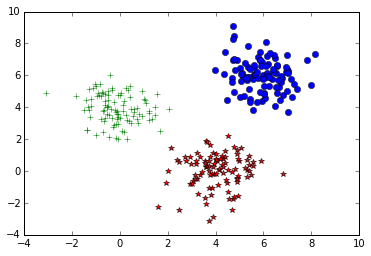

In [46]:
#HW 10.3 - Data Visualization
plt.plot(samples1[:, 0], samples1[:, 1],'*', color = 'red')
plt.plot(samples2[:, 0], samples2[:, 1],'o',color = 'blue')
plt.plot(samples3[:, 0], samples3[:, 1],'+',color = 'green')
plt.show()

###HW 10.3 - Main Implementation

In [43]:
#HW 10.3 - Useful helper functions

#Calculate which class each data point belongs to
def nearest_centroid(line):
    x = np.array([float(f) for f in line.split(',')])
    closest_centroid_idx = np.sum((x - centroids)**2, axis=1).argmin()
    return (closest_centroid_idx,(x,1))

#plot centroids and data points for each iteration
def plot_iteration(means):
    plt.plot(samples1[:, 0], samples1[:, 1], '.', color = 'blue')
    plt.plot(samples2[:, 0], samples2[:, 1], '.', color = 'blue')
    plt.plot(samples3[:, 0], samples3[:, 1],'.', color = 'blue')
    plt.plot(means[0][0], means[0][1],'*',markersize =10,color = 'red')
    plt.plot(means[1][0], means[1][1],'*',markersize =10,color = 'red')
    plt.plot(means[2][0], means[2][1],'*',markersize =10,color = 'red')
    plt.show()

Iteration 1
[array([ 5.90806069,  4.01515464]), array([ 1.49840143,  2.17055351]), array([ 5.5597729 ,  6.93622553])]
Within Set Sum of Squared Error = 703.997976463


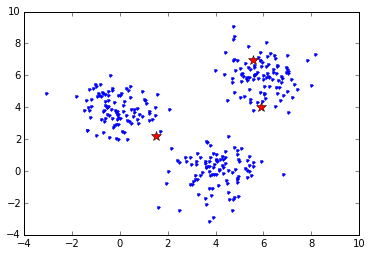


Iteration 10
[array([ 4.04297834,  0.00844429]), array([ 5.93730237,  6.01731357]), array([-0.15293117,  3.9124257 ])]
Within Set Sum of Squared Error = 351.542672935


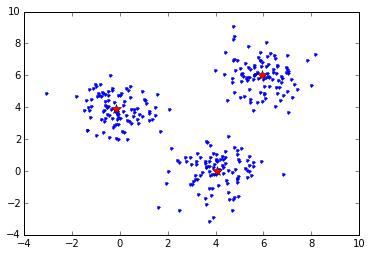


Iteration 20
[array([ 4.04297834,  0.00844429]), array([ 5.93730237,  6.01731357]), array([-0.15293117,  3.9124257 ])]
Within Set Sum of Squared Error = 351.542672935


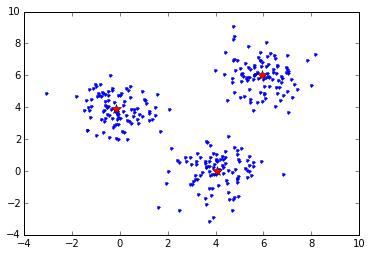


Iteration 100
[array([-0.15293117,  3.9124257 ]), array([ 5.93730237,  6.01731357]), array([ 4.04297834,  0.00844429])]
Within Set Sum of Squared Error = 351.542672935


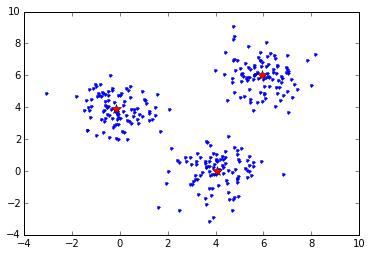

In [62]:
#HW 10.3 - Main driver
from pyspark.mllib.clustering import KMeans, KMeansModel

# Initialization: initialization of parameter is fixed to show an example
centroids = np.array([[0.0,0.0],[2.0,2.0],[0.0,7.0]])

#list of iterations that we want to plot
iterations_to_plot=[1,10,20,100]
K = 3

def error(point,clusters):
    center = clusters.centers[clusters.predict(point)]
    return sqrt(sum([x**2 for x in (point - center)]))

D = sc.textFile("./data.csv")
parsedData = D.map(lambda line: array([float(x) for x in line.split(',')])).cache()

for i in iterations_to_plot:
    clusters = KMeans.train(parsedData,K, maxIterations=i,runs=1,initializationMode="random")

    centroids=clusters.clusterCenters
    WSSSE = parsedData.map(lambda point: error(point,clusters)).reduce(lambda x, y: x + y)

    
    print "Iteration " + str(i)
    print centroids
    print("Within Set Sum of Squared Error = " + str(WSSSE))
    plot_iteration(centroids)
    print ""

### HW 10.3 - Discussion

Here, we see that the MLlib KMeans implementation converges relatively quickly (less than 10 iterations) and produces centroids that are very close to the initial values that we set during the sample data generation process earlier.

##HW 10.4

###HW 10.4 - Problem Statement
Using the KMeans code (homegrown code) provided repeat the experiments in HW10.3. Comment on any differences between the results in HW10.3 and HW10.4. Explain.

###HW 10.4 - Implementation

Iteration 1
[[ 1.25784386 -0.04200977]
 [ 3.87881341  2.70676912]
 [ 1.96537387  5.7205435 ]]
Within Set Sum of Squared Error = 2395.88191158


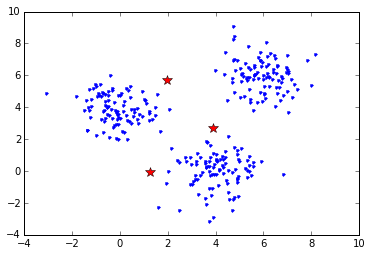

Iteration 10
[[ 4.04297834  0.00844429]
 [ 5.93730237  6.01731357]
 [-0.15293117  3.9124257 ]]
Within Set Sum of Squared Error = 2682.45642774


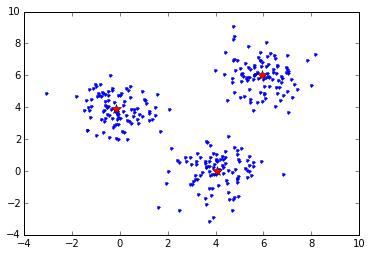

Iteration 20
[[ 4.04297834  0.00844429]
 [ 5.93730237  6.01731357]
 [-0.15293117  3.9124257 ]]
Within Set Sum of Squared Error = 2682.45642774


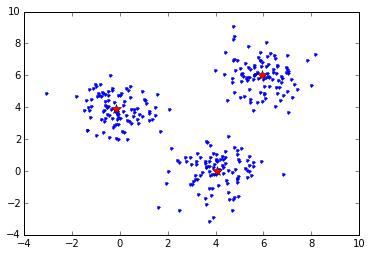

Iteration 100
[[ 4.04297834  0.00844429]
 [ 5.93730237  6.01731357]
 [-0.15293117  3.9124257 ]]
Within Set Sum of Squared Error = 2682.45642774


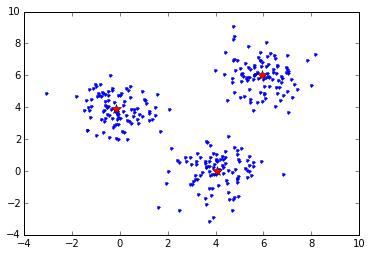

In [77]:
#HW 10.4 - Main Job

def error(center, point):
    """We need a modified version of this function to work in the homegrown context"""
    return sqrt(np.sum([x**2 for x in (point - center)]))

K = 3
# Initialization: initialization of parameter is fixed to show an example
centroids = np.array([[0.0,0.0],[2.0,2.0],[0.0,7.0]])

#list of iterations that we want to plot
iterations_to_plot=[1,10,20,100]

D = sc.textFile("./data.csv").cache()
parsedData = D.map(lambda line: array([float(x) for x in line.split(',')]))

for i in range(1,101):  
    res = D.map(nearest_centroid).reduceByKey(lambda x,y : (x[0]+y[0],x[1]+y[1])).collect()

    res = sorted(res,key = lambda x : x[0])  #sort based on clusted ID
    centroids_new = np.array([x[1][0]/x[1][1] for x in res])  #divide by cluster size
    centroids = centroids_new
    if i in iterations_to_plot:
        WSSSE = parsedData.map(lambda point:error(centroids_new, point)).reduce(lambda x, y: x + y)
        print "Iteration " + str(i)
        print centroids
        print("Within Set Sum of Squared Error = " + str(WSSSE))
        plot_iteration(centroids)
    


### HW 10.4 - Discussion

Both the MLlib implementation and the homegrown version produce comparable cluster centroids and converge quickly (within the iterations we're examining, centroid locations do not change after the 10th iteration for either implementation).  Interestingly, the WSSSE values are higher for the homegrown implementation than for the MLlib version.

# OPTIONAL PROBLEMS BELOW:

## HW 10.5

### HW 10.5 - Problem Statement

Using the KMeans code provided modify it to do a weighted KMeans and repeat the experiements in HW10.3. Comment on any differences between the results in HW10.3 and HW10.5. Explain.

NOTE: Weight each example as follows using the inverse vector length (Euclidean norm): 

weight(X)= 1/||X||, 

where ||X|| = SQRT(X.X)= SQRT(X1^2 + X2^2)

Here X is vector made up of X1 and X2.

### HW 10.5 - Implementation

In [111]:
# HW 10.5 - Define Weighted Reduce Function
def weighted_reduce(p1, p2):
    current_center=p1[0]
    p1_count=p1[1]
    point=p2[0]
    p2_count=p2[1]
    delta_x=point[0]-current_center[0]
    delta_y=point[1]-current_center[1]
    weight=1/sqrt(delta_x**2+delta_y**2)
    output=((point[0]+current_center[0])*weight,(point[1]+current_center[1])*weight)
    return (np.array(output),p1_count+p2_count)

Iteration 1
[[ 0.01997484  0.01097956]
 [ 0.00826906  0.00333119]
 [ 0.20015229  0.25003104]]
Within Set Sum of Squared Error = 2888.8078644


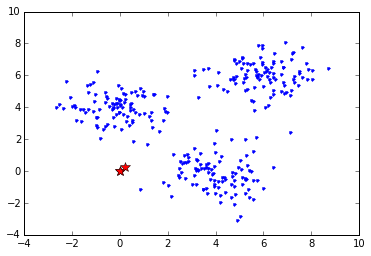

Iteration 10
[[ 0.01532643 -0.00067953]
 [-0.00168352  0.01789049]]
Within Set Sum of Squared Error = 2391.98981196


IndexError: index 2 is out of bounds for axis 0 with size 2

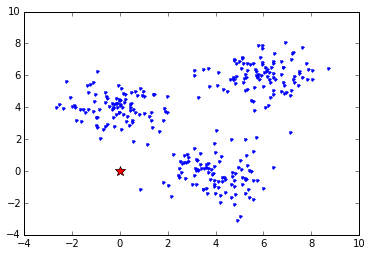

In [114]:
# HW 10.5 - Main job

from math import sqrt
from numpy import array

def error(center, point):
    """We need a modified version of this function to work in the homegrown context"""
    return sqrt(np.sum([x**2 for x in (point - center)]))

#Calculate which class each data point belongs to
def nearest_centroid(x):
    closest_centroid_idx = np.sum((x - centroids)**2, axis=1).argmin()
    return (closest_centroid_idx,(x,1))

K = 3
# Initialization: initialization of parameter is fixed to show an example
centroids = np.array([[0.0,0.0],[2.0,2.0],[0.0,7.0]])

#list of iterations that we want to plot
iterations_to_plot=[1,10,20,100]

D = sc.textFile("./data.csv").cache()
parsedData = D.map(lambda line: array([float(x) for x in line.split(',')]))

for i in range(1,101):
    #Here's where we modify the reduceByKey transform to accommodate our weights
    
    #ORIGINAL VERSION FOR REFERENCE
    #res = parsedData.map(nearest_centroid).reduceByKey(lambda x,y : (x[0]+y[0],x[1]+y[1])).collect()

    #WEIGHTED VERSION
    res = parsedData.map(nearest_centroid).reduceByKey(weighted_reduce).collect()

    res = sorted(res,key = lambda x : x[0])  #sort based on clusted ID
    centroids_new = np.array([x[1][0]/x[1][1] for x in res])  #divide by cluster size
    centroids = centroids_new
    if i in iterations_to_plot:
        WSSSE = parsedData.map(lambda point:error(centroids_new, point)).reduce(lambda x, y: x + y)
        print "Iteration " + str(i)
        print centroids
        print("Within Set Sum of Squared Error = " + str(WSSSE))
        plot_iteration(centroids)
    


Our custom weighting function does run without errors, but the fact that all the centroids converge to the same points indicates a bug in how the weights themselves are implemented.

## HW 10.6

### HW 10.6.1 - Problem Statement

Using the [linear regression notebook:](https://www.dropbox.com/s/atzqkc0p1eajuz6/LinearRegression-Notebook-Challenge.ipynb?dl=0), generate 2 sets of data with 100 data points using the data generation code provided and plot each in separate plots. Call one the training set and the other the testing set.

Using MLLib's LinearRegressionWithSGD train up a linear regression model with the training dataset and evaluate with the testing set. What a good number of iterations for training the linear regression model? Justify with plots and words. 

### HW 10.6.1 - Implementation

In [37]:
# HW 10.6.1 - Data Generation
import numpy as np
import csv

def data_generate(fileName, w=[0,0], size=100):
    np.random.seed(0)
    x = np.random.uniform(-4, 4, size)
    noise = np.random.normal(0, 2, size)
    y = (x * w[0] + w[1] + noise)
    data = zip(y, x)
    with open(fileName,'wb') as f:
        writer = csv.writer(f)
        for row in data:
            writer.writerow(row)
    return True

w = [8,-2]
data_generate('regressiondata_train.csv', w, 100)
data_generate('regressiondata_test.csv', w, 100)

Training Data


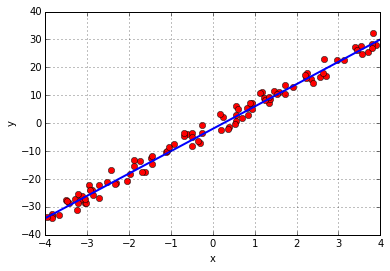


Test Data


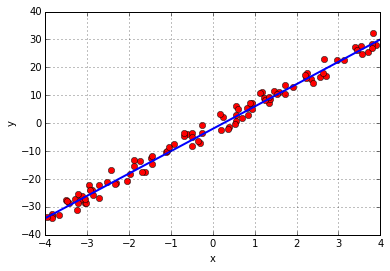

In [38]:
# HW 10.6.1 - Data Visualization

def dataPlot(file, w):
    with open(file, 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            plt.plot(float(row[1]), float(row[0]),'o'+'r')
    plt.xlabel("x")
    plt.ylabel("y")
    x = [-4, 4]
    y = [(i * w[0] + w[1]) for i in x]
    plt.plot(x,y, linewidth=2.0)
    plt.grid()
    plt.show()

print "Training Data"
dataPlot('regressiondata_train.csv',w)
print ""
print "Test Data"
dataPlot('regressiondata_test.csv',w)

1 iterations:
(weights=[43.420647014], intercept=-3.356525583044622)


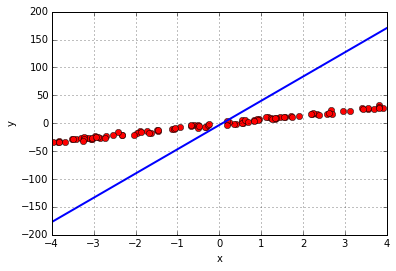


2 iterations:
(weights=[-91.3272568236], intercept=3.3259677691033263)


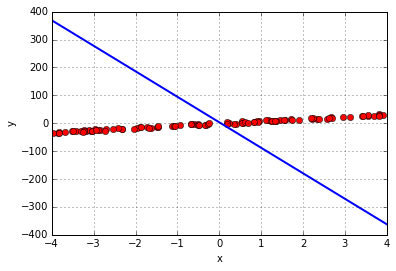


5 iterations:
(weights=[503.992859255], intercept=-26.278127537414093)


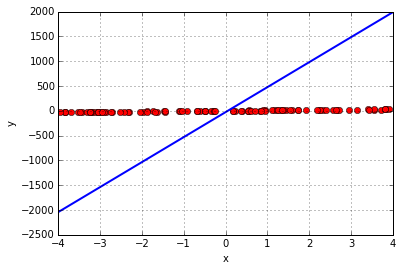


10 iterations:
(weights=[-298.445355872], intercept=13.616204267077855)


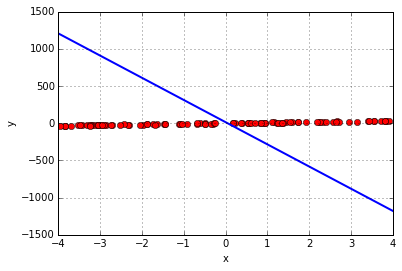


15 iterations:
(weights=[16.7683204364], intercept=-2.05546494112727)


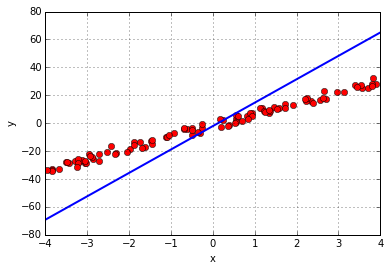


20 iterations:
(weights=[7.97257579041], intercept=-1.6181780801746715)


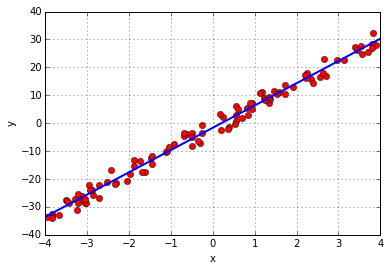


25 iterations:
(weights=[7.98393748404], intercept=-1.6187449131887346)


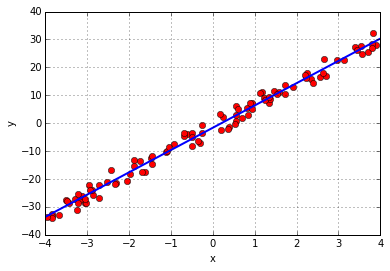


50 iterations:
(weights=[7.98393748404], intercept=-1.6187449131887346)


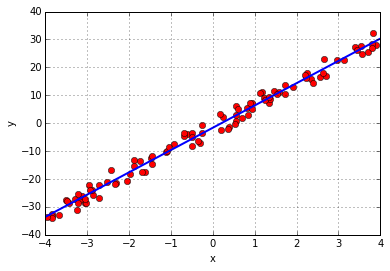

In [29]:
#HW 10.6.1 - Building Models

from pyspark.mllib.regression import LabeledPoint, LinearRegressionWithSGD, LinearRegressionModel

# Load and parse the data
def parsePoint(line):
    values = [float(x) for x in line.split(',')]
    return LabeledPoint(values[0], values[1:])

data = sc.textFile("regressiondata_train.csv")
parsedData = data.map(parsePoint)

# Build the model
iterations=[1,2,5,10,15,20,25,50]
for i in iterations:
    print str(i)+" iterations:"
    model = LinearRegressionWithSGD.train(parsedData, intercept=True, iterations=i)
    print model
    w=[model.weights[0],model.intercept]
    dataPlot("regressiondata_test.csv",w)
    print ""


### HW 10.6.1 - Discussion

As we can see in the plots above, the initial fit that we get via the first few iterations of gradient descent in spark is pretty bad. It's only after 20 or so iterations that we start to really converge to the appropriate solution. To be on the safe side, we could either stop between 25-30 iterations to give ourselves a buffer or we could change how we implemented this to enable us to check the weights after each iteration.  This would enable us to check for convergence after each iteration based on the amount of change in the weights.  If it fell below a stopping criterion we felt comfortable with, we'd declare victory.

### HW 10.6.2 - Problem Statement

In the notebook provide, in the cell labeled "Gradient descent (regularization)".

Fill in the blanks and get this code to work for LASSO and RIDGE linear regression.

Using the data from 10.6.1 tune the hyper parameters of your LASSO and RIDGE regression. Report your findings with words and plots.


### HW 10.6.2 - Implementation

In [9]:
#HW 10.6.2 - Defining our main GD function

def linearRegressionGDReg(data, wInitial=None, learningRate=0.05, iterations=50, regParam=0.01, regType=None):
    featureLen = len(data.take(1)[0])-1
    n = data.count()
    if wInitial is None:
        w = np.random.normal(size=featureLen) # w should be broadcasted if it is large
    else:
        w = wInitial
    for i in range(iterations):
        wBroadcast = sc.broadcast(w)
        gradient = data.map(lambda d: -2 * (d[0] - np.dot(wBroadcast.value, d[1:])) * np.array(d[1:])) \
                    .reduce(lambda a, b: a + b)
        if regType == "Ridge":
            wReg=w**2 #Here we use the squared value of the coefficients
        elif regType == "Lasso":
            wReg=abs(w) #Here we use the absolute value
        else:
            #Here we have no regularization term, so just make a vector of zeros
            wReg = np.zeros(w.shape[0])
        gradient = gradient + regParam * wReg  #gradient:  GD of Sqaured Error+ GD of regularized term 
        w = w - learningRate * gradient / n
    return w

In [31]:
# HW 10.6.2 - Load data and compare results for different regularization schemes

data = sc.textFile('regressiondata_train.csv').map(lambda line: [float(v) for v in line.split(',')]+[1.0]).cache()
np.random.seed(400)
print "50 iterations, no regularization:"
w0=linearRegressionGDReg(data, iterations=50, regParam=0.1)
print w0
print ""
print "50 iterations, ridge regularization:"
w1=linearRegressionGDReg(data, iterations=50, regParam=0.1, regType="Ridge")
print w1
print ""
print "50 iterations, lasso regularization:"
w2=linearRegressionGDReg(data, iterations=50, regParam=0.1, regType="Lasso")
print w2

50 iterations, no regularization:
[ 7.9847391 -1.6085985]

50 iterations, ridge regularization:
[ 7.97872799 -1.6106909 ]

50 iterations, lasso regularization:
[ 7.98415359 -1.60559281]


Ridge Regularization Parameter= 0.0
[ 7.98456869 -1.61202609]


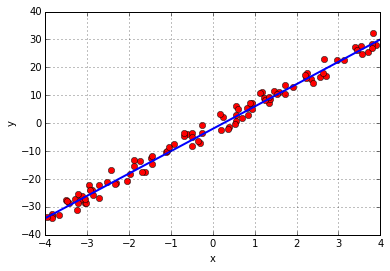


Ridge Regularization Parameter= 0.1
[ 7.9783789  -1.61772769]


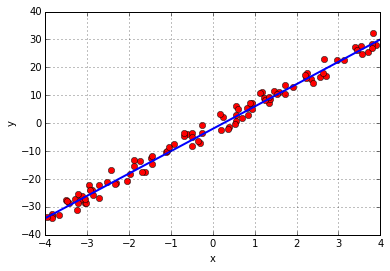


Ridge Regularization Parameter= 0.2
[ 7.97290081 -1.60942754]


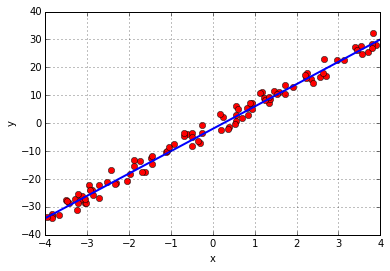


Ridge Regularization Parameter= 0.3
[ 7.96649203 -1.62028318]


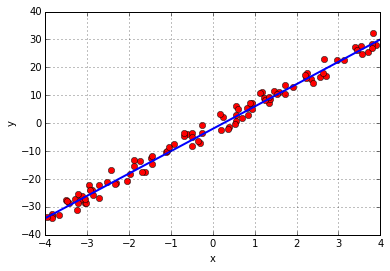


Ridge Regularization Parameter= 0.4
[ 7.96088535 -1.61526044]


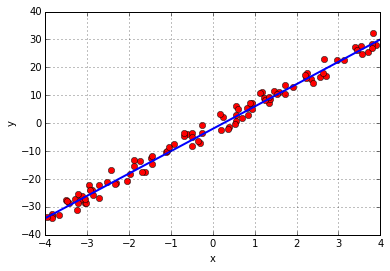


Ridge Regularization Parameter= 0.5
[ 7.95476102 -1.62108855]


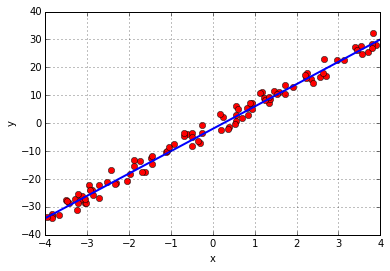


Ridge Regularization Parameter= 0.6
[ 7.94879843 -1.62399242]


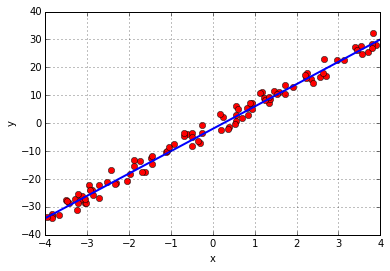


Ridge Regularization Parameter= 0.7
[ 7.94252452 -1.6336109 ]


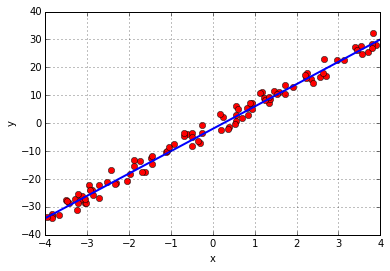


Ridge Regularization Parameter= 0.8
[ 7.9369768  -1.62875338]


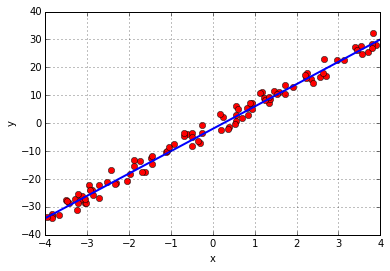


Ridge Regularization Parameter= 0.9
[ 7.93100461 -1.63292278]


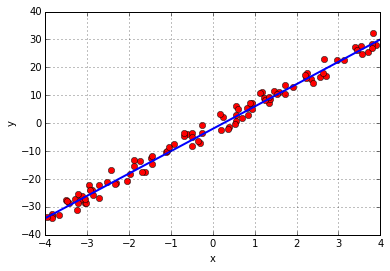

In [40]:
# HW 10.6.2 - Test different hyperparameters for Ridge Regression
for i in np.arange(0,1,0.1):
    print "Ridge Regularization Parameter= "+str(i)
    w1=linearRegressionGDReg(data, iterations=50, regParam=i, regType="Ridge")
    print w1
    dataPlot("regressiondata_test.csv",w)
    print ""

Lasso Regularization Parameter= 0.0
[ 7.98459468 -1.61150336]


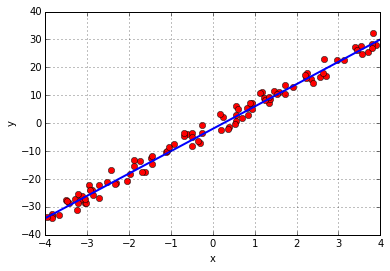


Lasso Regularization Parameter= 0.1
[ 7.98357329 -1.61726745]


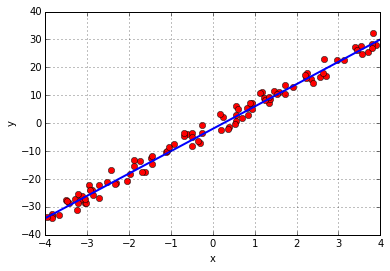


Lasso Regularization Parameter= 0.2
[ 7.98358537 -1.60224054]


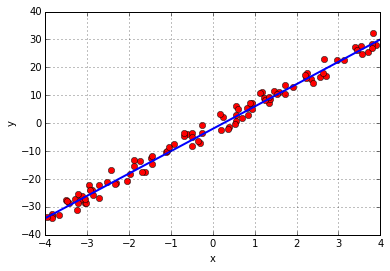


Lasso Regularization Parameter= 0.3
[ 7.98228716 -1.61358223]


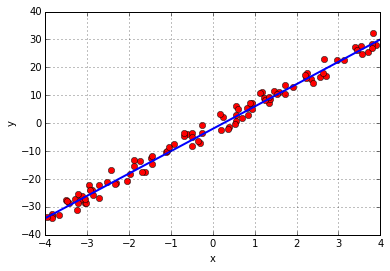


Lasso Regularization Parameter= 0.4
[ 7.98141422 -1.61637032]


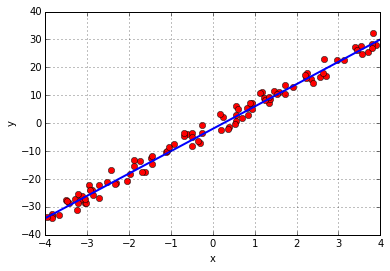


Lasso Regularization Parameter= 0.5
[ 7.9804354  -1.62129421]


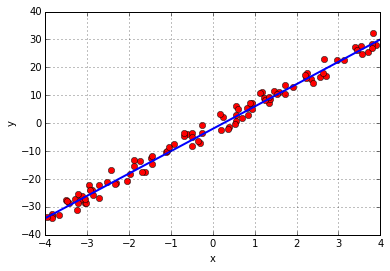


Lasso Regularization Parameter= 0.6
[ 7.97969528 -1.62141545]


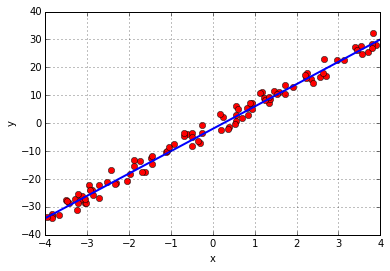


Lasso Regularization Parameter= 0.7
[ 7.97904585 -1.61971237]


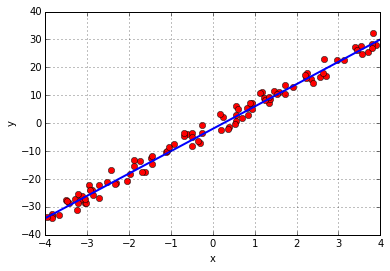


Lasso Regularization Parameter= 0.8
[ 7.97842998 -1.61733496]


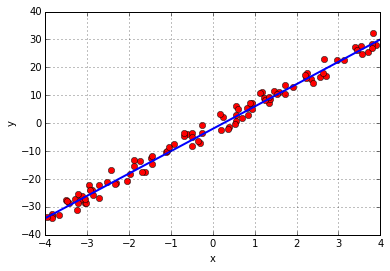


Lasso Regularization Parameter= 0.9
[ 7.97734706 -1.6243724 ]


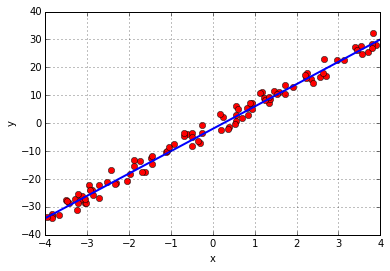

In [41]:
#HW 10.6.2 - Test different hyperparameters for Lasso Regression
for i in np.arange(0,1,0.1):
    print "Lasso Regularization Parameter= "+str(i)
    w1=linearRegressionGDReg(data, iterations=50, regParam=i, regType="Lasso")
    print w1
    dataPlot("regressiondata_test.csv",w)
    print ""

All in all, the addition of the regularization terms didn't change our results too much.  In general, we're underestimating the value of the slope of the line (which we know to be 2).  We seem to do better with a higher regularization coefficient, on the order of 0.5 and to 0.6.

## End of Submission